In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your imbalanced data into a Pandas DataFrame
data = pd.read_csv('Chronic_Kidney_disease.csv')


In [2]:
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

Cross-Validation Accuracy Scores: [0.984375, 0.984375, 1.0, 1.0, 0.953125]
Mean Accuracy: 0.984375
Average Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        39
           2       0.92      0.96      0.94        25

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64

Average Confusion Matrix:
[[38  0]
 [ 0 24]]
Final Model Test Results:
Accuracy: 0.9875
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           2       0.97      1.00      0.98        28

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Confusion Matrix:
 [[51  1]
 [ 0 28]]


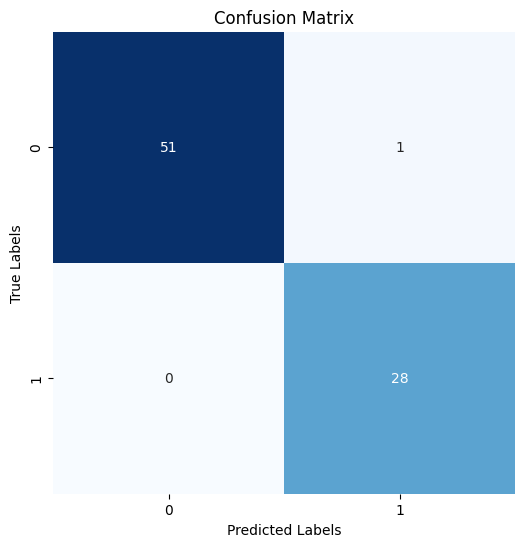

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Drop rows with missing values
data.dropna(inplace=True)

# Define features and target variable
X = data.drop('classification', axis=1)
y = data['classification']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)
svm_classifier = SVC(probability=True, random_state=42)

# Create an ensemble of classifiers using VotingClassifier
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('gb', gb_classifier),
    ('svm', svm_classifier),
], voting='soft')

# Define cross-validation strategy using StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Initialize lists to store results
accuracy_scores = []
classification_reports = []
confusion_matrices = []

# Perform cross-validation with different classifiers
for train_index, val_index in cv.split(X_train, y_train):
    X_fold_train, y_fold_train = X_train.iloc[train_index], y_train.iloc[train_index]
    X_fold_val, y_fold_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # Train the ensemble classifier
    ensemble_classifier.fit(X_fold_train, y_fold_train)
    
    # Make predictions on the validation set
    y_pred = ensemble_classifier.predict(X_fold_val)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_fold_val, y_pred)
    report = classification_report(y_fold_val, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_fold_val, y_pred)
    
    accuracy_scores.append(accuracy)
    classification_reports.append(report)
    confusion_matrices.append(conf_matrix)

# Print average results
print(f"Cross-Validation Accuracy Scores: {accuracy_scores}")
print(f"Mean Accuracy: {np.mean(accuracy_scores)}")
print("Average Classification Report:")
# Print the classification report as a string
print(classification_report(y_fold_val, y_pred))
print("Average Confusion Matrix:")
print(np.mean(confusion_matrices, axis=0).astype(int))

# Train the final model on the entire training data
ensemble_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

# Evaluate the final model on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)  # Add zero_division parameter
conf_matrix = confusion_matrix(y_test, y_pred)

print("Final Model Test Results:")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
